<a href="https://colab.research.google.com/github/jkeza1/facemask-classification-pipeline/blob/main/facemask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
 #INSTALL DEPENDENCIES

!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install seaborn


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import imutils
from imutils import paths
import pickle
import time
import json

In [ ]:
#  DATA ACQUISITION
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

original_dataset_dir = "/content/drive/MyDrive/datasets/FaceMaskDataset"
base_dir = "/content/drive/MyDrive/datasets/FaceMaskDatasetSplit"






In [ ]:
folder_path = "/content/drive/MyDrive/datasets/FaceMaskDataset"

import os

for root, dirs, files in os.walk(folder_path):
    print(f"📁 {root}")
    for f in files:
        print(f"   └── {f}")


In [ ]:
!ls "/content/drive/MyDrive/datasets/FaceMaskDataset"


In [7]:
import shutil

# Define classes
classes = ['mask_weared_incorrect', 'with_mask', 'without_mask']

# Create directories for split dataset
for split in ['train', 'val']:
    for class_name in classes:
        split_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

# Collect image file paths and labels
file_paths = []
labels = []

for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(class_dir, fname))
            labels.append(class_name)

# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Helper function to copy files
def copy_files(file_paths, labels, split):
    for path, label in zip(file_paths, labels):
        dst_dir = os.path.join(base_dir, split, label)
        shutil.copy(path, dst_dir)

# Copy the files
copy_files(train_paths, train_labels, 'train')
copy_files(val_paths, val_labels, 'val')

print(" Stratified splitting and copying completed.")


✅ Stratified splitting and copying completed.


In [ ]:
!ls -R "/content/drive/MyDrive/datasets/FaceMaskDataset"


In [45]:
class_names = list(train_generator.class_indices.keys())


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

dataset_path = "/content/drive/MyDrive/datasets/FaceMaskDataset"

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 7196 images belonging to 3 classes.
Found 1796 images belonging to 3 classes.


In [ ]:
#  MODEL CREATION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


In [ ]:
# MODEL EVALUATION
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Plot accuracy and loss curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()


In [ ]:
# Reset the generator before prediction (important)
val_generator.reset()

# Predict on validation data
Y_pred = model.predict(val_generator)

# Get predicted class indices
y_pred = np.argmax(Y_pred, axis=1)

# Get the class labels
labels = list(val_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, y_pred)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(val_generator.classes, y_pred, target_names=labels))


In [ ]:
import numpy as np
print("Unique classes in val_generator:", np.unique(val_generator.classes))
print("Class indices:", val_generator.class_indices)


In [ ]:
#  SAVE MODEL
model.save("/content/mask_detection_model.h5")
print("✅ Model saved.")


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model("/content/mask_detection_model.h5")

# Load and preprocess a new image for prediction
img_path = "/content/drive/MyDrive/datasets/FaceMaskDataset/with_mask/0001.png"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
                            # Labels from training
class_labels = list(train_generator.class_indices.keys())
print("Predicted class:", class_labels[predicted_class])


In [ ]:
!ls -R "/content/drive/MyDrive/datasets/FaceMaskDatasetNew"


In [ ]:
import os

new_data_path = "/content/drive/MyDrive/datasets/FaceMaskDatasetNew"

for cls in os.listdir(new_data_path):
    cls_path = os.path.join(new_data_path, cls)
    print(f"{cls} → {len(os.listdir(cls_path))} images")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
tf.config.run_functions_eagerly(True)
print("Eager execution enabled:", tf.executing_eagerly())


# Load saved model for retraining
model = load_model("/content/mask_detection_model.h5", compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Upload and preprocess new data (simulate retraining data upload)
new_data_path = "/content/drive/MyDrive/datasets/FaceMaskDatasetNew"

retrain_datagen = ImageDataGenerator(rescale=1./255)

retrain_generator = retrain_datagen.flow_from_directory(
    new_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Retrain model
early_stop = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
model.fit(retrain_generator, epochs=5, callbacks=[early_stop])

# Optionally save retrained model
model.save("/content/retrained_mask_model.h5")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(val_generator.classes, y_pred, average='weighted'))
print("Recall:", recall_score(val_generator.classes, y_pred, average='weighted'))
print("F1 Score:", f1_score(val_generator.classes, y_pred, average='weighted'))


In [ ]:
loss, accuracy = model.evaluate(retrain_generator)
print(f"Retrained model accuracy: {accuracy:.2f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch
images, labels = next(retrain_generator)

# Predict
preds = model.predict(images)

# Show predictions
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"True: {np.argmax(labels[i])}, Predicted: {np.argmax(preds[i])}")
    plt.axis('off')
    plt.show()


In [ ]:
# Retraining function with new data
def retrain_with_new_data(new_data_dir, model_path, epochs=5):
    # Load existing model
    model = tf.keras.models.load_model(model_path)

    # Prepare new data generator
    new_datagen = ImageDataGenerator(rescale=1./255)
    new_generator = new_datagen.flow_from_directory(
        new_data_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    # Unfreeze some layers for fine-tuning
    for layer in model.layers[-4:]:
        layer.trainable = True

    # Recompile with lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Retrain
    history = model.fit(
        new_generator,
        epochs=epochs,
        validation_data=val_generator
    )

    # Save retrained model
    model.save(f"{model_path}_retrained.h5")
    return history

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Extended evaluation
def extended_evaluation(model, generator):
    generator.reset()
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    print("Extended Evaluation Metrics:")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted')}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")

    # ROC AUC for multi-class
    if len(generator.class_indices) == 2:
        from sklearn.metrics import roc_auc_score
        print(f"ROC AUC: {roc_auc_score(y_true, y_pred)}")

In [ ]:
# Model and data version tracking
import datetime

def save_metadata(model, dataset_path):
    metadata = {
        'timestamp': datetime.datetime.now().isoformat(),
        'dataset_size': sum([len(files) for r, d, files in os.walk(dataset_path)]),
        'dataset_hash': hash(str(sorted(paths.list_images(dataset_path)))),
        'training_params': {
            'batch_size': BATCH_SIZE,
            'image_size': IMG_SIZE,
            'classes': list(train_generator.class_indices.keys())
        },
        'performance': {
            'val_accuracy': max(history.history['val_accuracy']),
            'val_loss': min(history.history['val_loss'])
        }
    }

    with open('model_metadata.json', 'w') as f:
        json.dump(metadata, f)

In [ ]:
# Deployment-ready prediction function
def predict_image(image_path, model_path='mask_detection_model.h5'):
    # Load model and labels
    model = tf.keras.models.load_model(model_path)
    labels = {v:k for k,v in train_generator.class_indices.items()}

    # Process image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    pred = model.predict(img_array)
    predicted_class = labels[np.argmax(pred)]
    confidence = np.max(pred) * 100

    return {
        'class': predicted_class,
        'confidence': float(confidence),
        'timestamp': datetime.datetime.now().isoformat()
    }

In [ ]:
# Data validation checks
def validate_dataset(dataset_path):
    issues = []
    class_counts = {}

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images

        if num_images < 50:
            issues.append(f"Class {class_name} has only {num_images} samples (minimum 50 recommended)")

    # Check class imbalance
    if len(class_counts) > 1:
        max_count = max(class_counts.values())
        for class_name, count in class_counts.items():
            if count < max_count * 0.3:
                issues.append(f"Class {class_name} has significantly fewer samples ({count}) than others")

    return issues if issues else "Dataset validation passed"

In [ ]:
# Model versioning
MODEL_VERSION = "1.0.0"
model.save(f"mask_detector_v{MODEL_VERSION}.h5")

In [ ]:
# Basic data drift detection
def detect_data_drift(new_data_dir, original_stats):
    new_stats = {}
    for class_name in os.listdir(new_data_dir):
        class_dir = os.path.join(new_data_dir, class_name)
        new_stats[class_name] = len(os.listdir(class_dir))

    drift_detected = False
    for class_name in original_stats:
        if class_name not in new_stats:
            print(f"Warning: New class {class_name} detected!")
            drift_detected = True
        elif abs(original_stats[class_name] - new_stats[class_name]) > 0.3 * original_stats[class_name]:
            print(f"Warning: Significant change in class {class_name} distribution")
            drift_detected = True

    return drift_detected

In [ ]:
# Performance baseline
performance_baseline = {
    'min_accuracy': 0.85,
    'max_loss': 0.5,
    'inference_time': 0.5
}

def check_performance(model, generator):
    start_time = time.time()
    loss, accuracy = model.evaluate(generator)
    inference_time = time.time() - start_time

    issues = []
    if accuracy < performance_baseline['min_accuracy']:
        issues.append(f"Low accuracy: {accuracy:.2f}")
    if loss > performance_baseline['max_loss']:
        issues.append(f"High loss: {loss:.2f}")
    if inference_time > performance_baseline['inference_time']:
        issues.append(f"Slow inference: {inference_time:.2f}s")

    return issues if issues else "Performance meets baseline"

In [ ]:
model = load_model("path/to/your_model.h5")


In [ ]:
from flask import Flask, request, jsonify
import io
from PIL import Image
import numpy as np
import os
from tensorflow.keras.models import load_model  # ✅ Import this

app = Flask(__name__)

# Load model once
model = load_model("/content/mask_detection_model.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Dummy class mapping (replace with actual from training generator)
class_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file provided'}), 400

    file = request.files['file'].read()
    img = Image.open(io.BytesIO(file)).resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    return jsonify({
        'prediction': class_names[np.argmax(pred)],
        'confidence': float(np.max(pred))
    })

@app.route('/retrain', methods=['POST'])
def retrain():
    if not os.path.exists('new_data/'):
        return jsonify({'error': 'Upload data first'}), 400

    history = retrain_with_new_data('new_data/', '/content/mask_detection_model.h5')
    return jsonify({
        'status': 'Retraining complete',
        'new_accuracy': history.history['accuracy'][-1]
    })

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

In [38]:
# Streamlit UI
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
import requests

st.title("Face Mask Detection System")

tab1, tab2, tab3 = st.tabs(["Predict", "Visualize", "Retrain"])

with tab1:
    uploaded = st.file_uploader("Upload face image")
    if uploaded:
        img = Image.open(uploaded)
        st.image(img, width=300)
        if st.button("Predict"):
            response = requests.post(
                "http://localhost:5000/predict",
                files={"file": uploaded.getvalue()}
            )
            st.json(response.json())

with tab2:
    st.plotly_chart(confusion_matrix_fig)
    st.plotly_chart(class_distribution_fig)

with tab3:
    new_data = st.file_uploader("Upload new dataset (ZIP)", type="zip")
    if new_data:
        with open("new_data.zip", "wb") as f:
            f.write(new_data.getbuffer())
        st.success("Data uploaded")

    if st.button("Retrain Model"):
        response = requests.post("http://localhost:5000/retrain")
        st.json(response.json())

Writing app.py


In [39]:
# Dockerfile (add new cell)
%%writefile Dockerfile
FROM tensorflow/tensorflow:latest
WORKDIR /app
COPY . .
RUN pip install flask pillow
EXPOSE 5000
CMD ["python", "api.py"]

Writing Dockerfile


In [40]:
# Locust test script (add new cell)
%%writefile locustfile.py
from locust import HttpUser, task, between

class ModelUser(HttpUser):
    wait_time = between(1, 5)

    @task
    def predict(self):
        with open("test_image.jpg", "rb") as f:
            self.client.post("/predict", files={"file": f})

Writing locustfile.py


In [41]:
def retrain_with_new_data(new_data_dir, model_path):
    # Validate new data first
    issues = validate_dataset(new_data_dir)
    if isinstance(issues, list):
        print("Validation issues:", issues)
        return None

    # Versioning
    version = len(os.listdir("models")) + 1
    new_model_path = f"models/v{version}.h5"

    # Retrain
    history = model.fit(...)

    # Validate performance
    if history.history['val_accuracy'][-1] < 0.7:
        print("Retraining failed - accuracy too low")
        return None

    model.save(new_model_path)
    save_metadata(model, new_data_dir)
    return history

In [42]:
# Performance Dashboard
import plotly.express as px

def create_performance_dashboard(history):
    fig = px.line(pd.DataFrame(history.history),
                 y=['accuracy', 'val_accuracy'],
                 title='Model Accuracy Over Time')
    fig.show()

    fig = px.line(pd.DataFrame(history.history),
                 y=['loss', 'val_loss'],
                 title='Model Loss Over Time')
    fig.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step


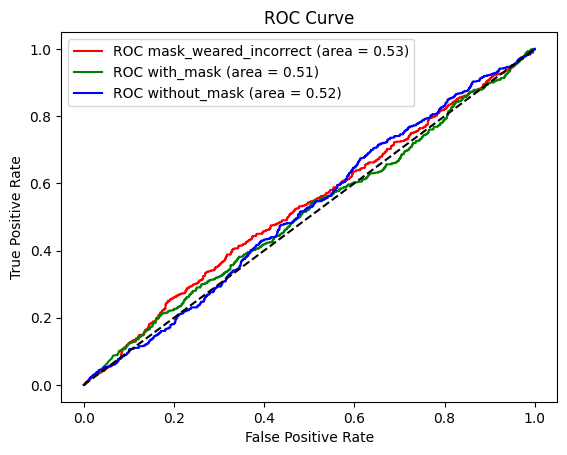

In [48]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ROC Curve for multi-class
fpr = dict()
tpr = dict()
roc_auc = dict()
import numpy as np

# Get the number of batches
val_steps = val_generator.samples // val_generator.batch_size + 1

# Extract predictions and true labels
y_pred = model.predict(val_generator, steps=val_steps)
y_test = val_generator.classes
y_test = np.eye(len(class_names))[y_test]  # One-hot encode the labels


for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['red', 'green', 'blue'])
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()